In [1]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [3]:
def f(x, y):
    "Objective function"
    return (x-3.14)**2 + (y-2.72)**2 + np.sin(3*x+1.41) + np.sin(4*y-1.73)

In [5]:
def levy_step(mu=1.5):
    """Generate a step length from a Levy distribution."""
    return np.random.pareto(mu) + 1  # Using Pareto distribution for Levy flight

In [161]:
for i in range(20):
    print(levy_step(1.5))

1.1319374642014095
1.3251640881763493
3.753654502865404
1.848045206044147
1.259138807984327
1.0477115065077336
1.1602647992972674
3.937009754064169
1.0201154598674647
6.234738735382249
1.6598196604669477
1.7270653519301635
6.085009000793961
2.4771478311525894
1.2245101517606976
1.321950787579131
1.836885062681381
2.1760510242848543
1.0010420202839536
1.9054525176863049


In [233]:
np.random.rand(1)[0]

0.3513437368829435

In [19]:
class Particle:
    def __init__(self, env, name, particles, X=np.array([0.1, 0.1]), c1=0.1, c2=0.1, w=0.8, levy_prob=0.1):
        self.env = env
        self.name = name
        self.particles = particles  # List of all particles
        self.c1 = c1
        self.c2 = c2
        self.w = w
        self.levy_prob = levy_prob  # Probability of taking a Levy flight

        self.X = X
        self.V = np.random.randn(2) * 0.1
        self.pbest_position = self.X.copy()
        self.pbest_fitness = f(self.X[0], self.X[1])

        self.nbest_position = self.X.copy()
        self.nbest_fitness = self.pbest_fitness

        self.positions = [self.X.copy()]

        self.process = env.process(self.run())

    def interact(self):
        """Interact with other particles based on proximity."""
        for particle in self.particles:
            if particle != self:
                distance = np.linalg.norm(self.X - particle.X) # Euclidean distance
                if distance < 1.0:  # Interaction threshold
                #    self.V += (self.X - particle.X) * 0.1  # Example interaction: repulsion
                    particle.receive(self.nbest_position, self.nbest_fitness)

    def receive(self, nbest_position, nbest_fitness):
        """update the personal nbest"""
        if nbest_fitness < self.nbest_fitness:
            self.nbest_position = nbest_position.copy()
            self.nbest_fitness = nbest_fitness
    
    def update(self):
        r1, r2 = np.random.rand(2)
        self.V = self.w * self.V + self.c1 * r1 * (self.pbest_position - self.X) + self.c2 * r2 * (self.nbest_position - self.X)
        self.X = self.X + self.V
        fitness = f(self.X[0], self.X[1])

        if fitness < self.pbest_fitness:
            self.pbest_position = self.X.copy()
            self.pbest_fitness = fitness

        if fitness < self.nbest_fitness:
            self.nbest_position = self.X.copy()
            self.nbest_fitness = fitness
        
        self.positions.append(self.X.copy())

    def run(self):
        i = 0;
        while True:
            if self.nbest_position is not None:
                self.update()
                if i%5 ==0:
                    self.interact()  # Interact with other particles after updating
            i = i + 1;
            yield self.env.timeout(1)

In [11]:
def simulate_pso():
    env = simpy.Environment()
    n_particles = 20

    particles = [Particle(env, f'Particle {i}', []) for i in range(n_particles)]
    for particle in particles:
        particle.particles = particles  # Give each particle the list of all particles

    global_best = particles[0]
    
    def update_nbest():
        while True:
            global_best = min(particles, key=lambda p: p.pbest_fitness)
            # for particle in particles:
            #     particle.nbest_position = global_best.pbest_position
            #     particle.nbest_fitness = global_best.pbest_fitness
            yield env.timeout(1)

    env.process(update_nbest())
    env.run(until=50)

    return [p.positions for p in particles], global_best.pbest_position, global_best.pbest_fitness

In [21]:
positions, nbest, nbest_obj = simulate_pso()

In [23]:
for i in positions:
    print(i[-1])

[1.26192854 0.15973763]
[1.26587989 0.16221537]
[1.26746341 0.16025799]
[1.25984532 0.16415302]
[1.26554332 0.15956406]
[1.27978815 0.15067247]
[1.26502935 0.15919753]
[1.2663473  0.16099625]
[1.26864209 0.1594661 ]
[1.26715398 0.16030065]
[1.26384113 0.15713956]
[1.27008368 0.15673639]
[1.26939812 0.16158204]
[1.26576622 0.16104779]
[1.26365933 0.15899858]
[1.26703176 0.15931271]
[1.25852267 0.16943429]
[1.26176148 0.15497206]
[1.2602222  0.16109762]
[1.26267471 0.1571765 ]


MovieWriter imagemagick unavailable; using Pillow instead.


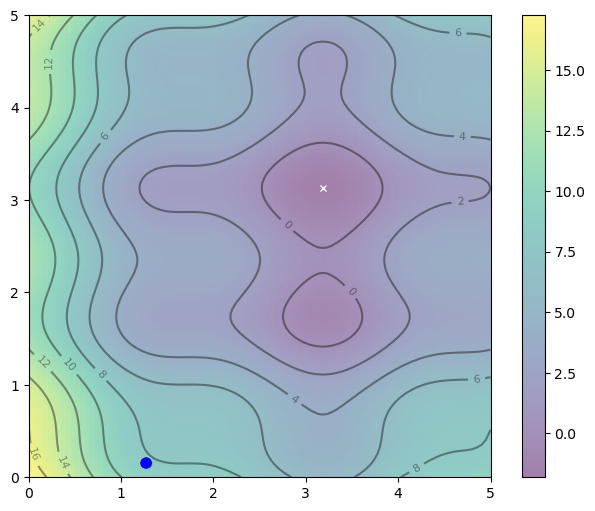

DPSO found best solution at f([1.26192854 0.15973763])=8.309562716820034


In [25]:
# Plotting and Animation
x, y = np.array(np.meshgrid(np.linspace(0, 5, 100), np.linspace(0, 5, 100)))
z = f(x, y)
x_min, y_min = x.ravel()[z.argmin()], y.ravel()[z.argmin()]

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
p_plot = ax.scatter(positions[0][0], positions[0][1], marker='o', color='blue', alpha=0.5)
nbest_plot = plt.scatter([nbest[0]], [nbest[1]], marker='*', s=100, color='black', alpha=0.4)

def animate(i):
    ax.clear()
    ax.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
    ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
    contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
    ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
    for pos in positions:
        p_plot = ax.scatter(pos[i][0], pos[i][1], marker='o', color='blue', alpha=0.5)
    nbest_plot.set_offsets(nbest.reshape(1, -1))
    return ax, p_plot, nbest_plot

anim = FuncAnimation(fig, animate, frames=len(positions[0]), interval=500, blit=False, repeat=True)
anim.save("PSO.gif", dpi=120, writer="imagemagick")
plt.show()

print("DPSO found best solution at f({})={}".format(nbest, nbest_obj))
